# 弧长参数化原理



在插补时，我们通常要计算点沿着曲线 $\mathbf{P}(u)$ 移动 $\Delta s$ 后的位置。传统插补算法通常是通过泰勒展开的二阶近似来计算，即：
$$
u_{i+1}=u_i+ \frac{\Delta s}{\left\Vert \mathbf{P}^{\prime}(u_i) \right\Vert} - \frac{(\Delta s)^2}{2\left\Vert \mathbf{P}^{\prime}(u_i) \right\Vert^4}\left\langle \mathbf{P}^{\prime\prime}(u_i), \mathbf{P}^{\prime}(u_i) \right\rangle
$$
这种方法最大的缺点就是计算过程中会有误差积累，导致最终走完整条曲线后，$u$ 的值不一定是 $1$，需要频繁进行校正。

另一种方法是使用弧长参数化，预先计算出曲线的弧长函数 $s(u)$，然后通过二分法求解 $s(u)=s_i+\Delta s$ 的 $u$ 值，这样就可以避免误差积累。但是，这种方法计算量较大，不适合实时计算。

一个更聪明的办法是，对弧长进行反插值，先计算一系列 $(u_1, s_1), (u_2, s_2), \cdots$，然后通过插值的方法得到一个$s\to u$的映射函数 $u^{-1}(s)$，这样就可以通过 $u^{-1}(s_i+\Delta s)$ 得到 $u_{i+1}$ 的值。这种方法的优点是计算量小，而且不会有误差积累。

In [1]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
def simpson(f, a, b):
    c = (a + b) / 2
    return (b - a) / 6 * (f(a) + 4 * f(c) + f(b))


def adaptive_simpson(f, a, b, tol, intervals):
    c = (a + b) / 2
    S_ab = simpson(f, a, b)
    S_ac = simpson(f, a, c)
    S_cb = simpson(f, c, b)
    if np.abs(S_ac + S_cb - S_ab) < tol:
        intervals.append((a, b, S_ac + S_cb))
        return S_ac + S_cb
    else:
        left = adaptive_simpson(f, a, c, tol / 2, intervals)
        right = adaptive_simpson(f, c, b, tol / 2, intervals)
        return left + right


class BSplineCurve:
    """Cubic B-spline curve with 5 control points."""

    def __init__(self, control_points):
        self.control_points = control_points
        self._init_curve()
        self.length = self.get_length(u=1)

    def _init_curve(self):
        self.knots = np.array(object=[0, 0, 0, 0, 0.5, 1, 1, 1, 1])
        self.degree = 3
        self.curve = BSpline(self.knots, self.control_points, self.degree)

    def get_length(self, u=1):
        self.intervals = []
        spline_length = adaptive_simpson(lambda t: arc_length_derivative(self.curve, t), 0, u, 1e-6, self.intervals)
        return spline_length

    def eval(self, u):
        return self.curve(u)

    def __call__(self, u):
        return self.eval(u)


def arc_length_derivative(curve: BSpline, t: float):
    """计算弧长导数"""
    # Calculate the first derivative of the curve at parameter t
    der = curve.derivative(nu=1)(t)
    der = np.array(der)
    # Return the magnitude of the derivative vector
    return np.linalg.norm(der)

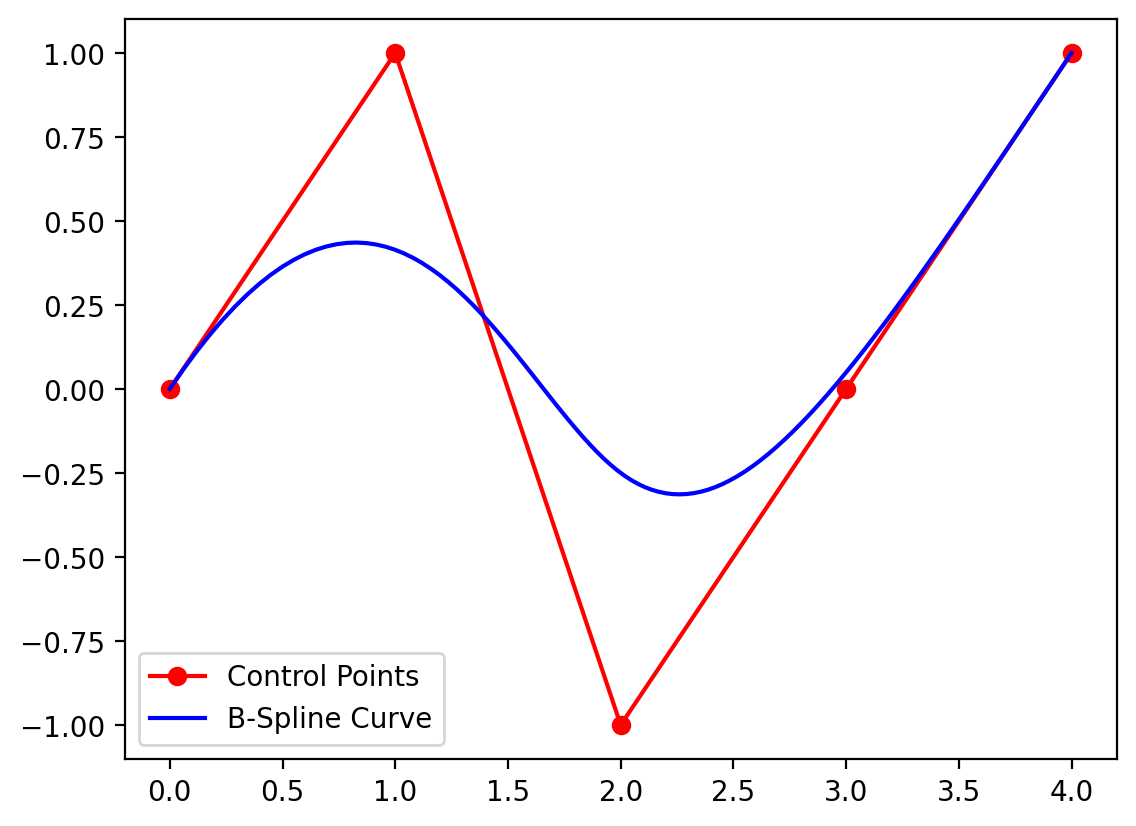

In [3]:
ctrlpts = np.array([[0, 0, 0], [1, 1, 0], [2, -1, 0], [3, 0, 0], [4, 1, 0]])
spline = BSplineCurve(ctrlpts)

# Plot the B-Spline curve
fig, ax = plt.subplots()
spline_points = np.array([spline(u) for u in np.linspace(0, 1, 100)])
ax.plot(ctrlpts[:, 0], ctrlpts[:, 1], "ro-", label="Control Points")
ax.plot(spline_points[:, 0], spline_points[:, 1], "b-", label="B-Spline Curve")
ax.legend()
plt.show()

一个首要的问题是，如何得到一系列精确的 $(u_1, s_1), (u_2, s_2), \cdots$，这里我们使用自适应Simpson积分法，并且将划分的子区间储存起来，以便后续插值。

In [4]:
intervals = spline.intervals
print("Number of intervals:", len(intervals))
print("Length of the curve:", spline.length)

print("Intervals:")
for i, (a, b, length) in enumerate(intervals):
    print(f"Interval {i + 1}: [{a:.6f}, {b:.6f}] with length {length:.6f}")

Number of intervals: 52
Length of the curve: 4.833840145302086
Intervals:
Interval 1: [0.000000, 0.031250] with length 0.245417
Interval 2: [0.031250, 0.062500] with length 0.209958
Interval 3: [0.062500, 0.078125] with length 0.093671
Interval 4: [0.078125, 0.093750] with length 0.087254
Interval 5: [0.093750, 0.109375] with length 0.081707
Interval 6: [0.109375, 0.125000] with length 0.077037
Interval 7: [0.125000, 0.140625] with length 0.073236
Interval 8: [0.140625, 0.156250] with length 0.070270
Interval 9: [0.156250, 0.171875] with length 0.068082
Interval 10: [0.171875, 0.187500] with length 0.066586
Interval 11: [0.187500, 0.218750] with length 0.130937
Interval 12: [0.218750, 0.234375] with length 0.065187
Interval 13: [0.234375, 0.250000] with length 0.065365
Interval 14: [0.250000, 0.265625] with length 0.065685
Interval 15: [0.265625, 0.281250] with length 0.066055
Interval 16: [0.281250, 0.296875] with length 0.066397
Interval 17: [0.296875, 0.312500] with length 0.066645


当自适应辛普森积分的精度提高到 `1e-7` 时，区间数目大致翻倍


In [5]:
intervals_new = []
spline_length_new = adaptive_simpson(lambda t: arc_length_derivative(spline.curve, t), 0, 1, 1e-7, intervals_new)
print("Number of intervals:", len(intervals_new))
print("Length of the curve:", spline_length_new)

Number of intervals: 96
Length of the curve: 4.83384013763831


接下来就是插值的问题了，这里我们直接使用 scipy 的 `interp1d` 函数，使用线性插值。

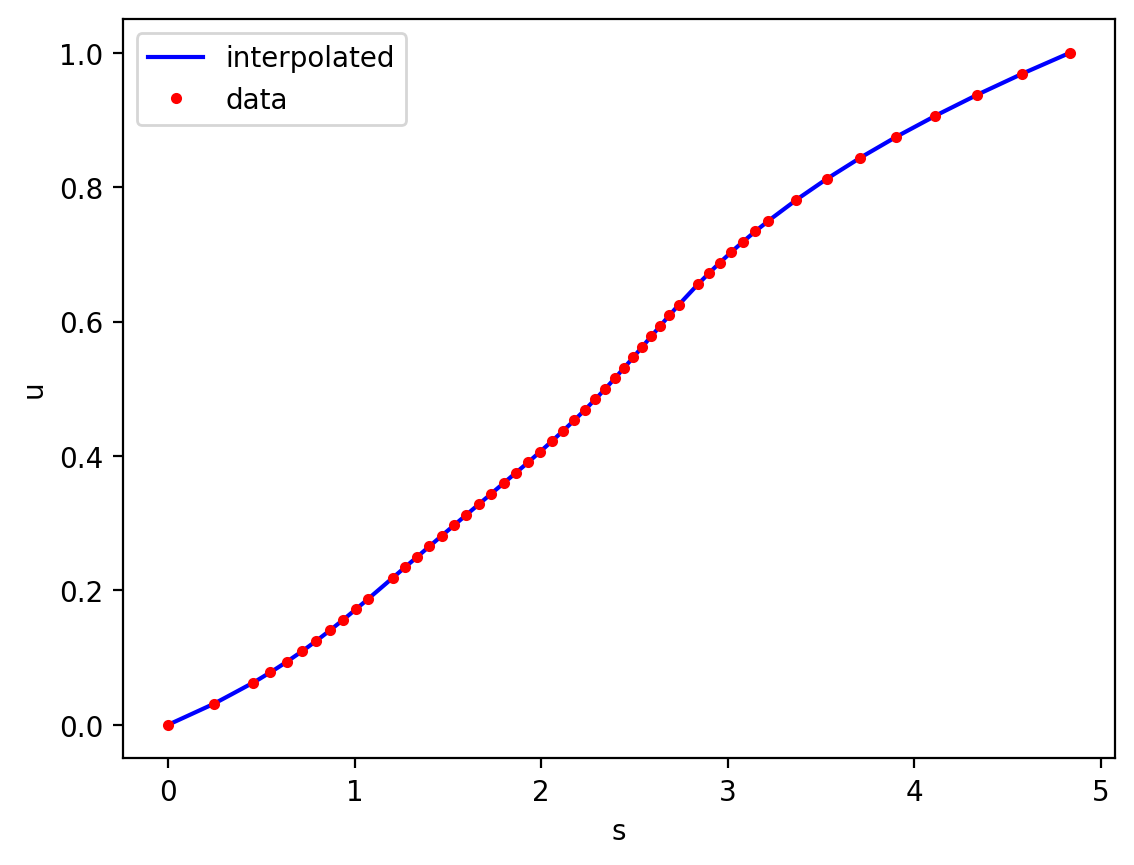

In [6]:
from scipy.interpolate import interp1d

u_values = [a for a, b, s in intervals]
s_values = np.cumsum([s for a, b, s in intervals])
u_values.append(intervals[-1][1])  # 添加最后一个 b 值
s_values[-1] = spline.length  # 修正最后一个 s 值
s_values = np.insert(s_values, 0, 0)  # 在开始处插入 s = 0
# 创建插值函数
s_to_u = interp1d(s_values, u_values, kind="linear")

s_grid = np.linspace(0, s_values[-1], 200)
u_interp = s_to_u(s_grid)
plt.plot(s_grid, u_interp, "b-", label="interpolated")
plt.plot(s_values, u_values, "r.", label="data")
plt.xlabel("s")
plt.ylabel("u")
plt.legend()
plt.show()

对于原始的曲线 $P(u)$，我们现在可以得到其弧长参数化后的曲线 $P(s)=P(u^{-1}(s))$，其中$s$是弧长，$u(s)$是$s$对应的$u$值。

我们可以对比等$u$划分和等$s$划分的曲线效果。


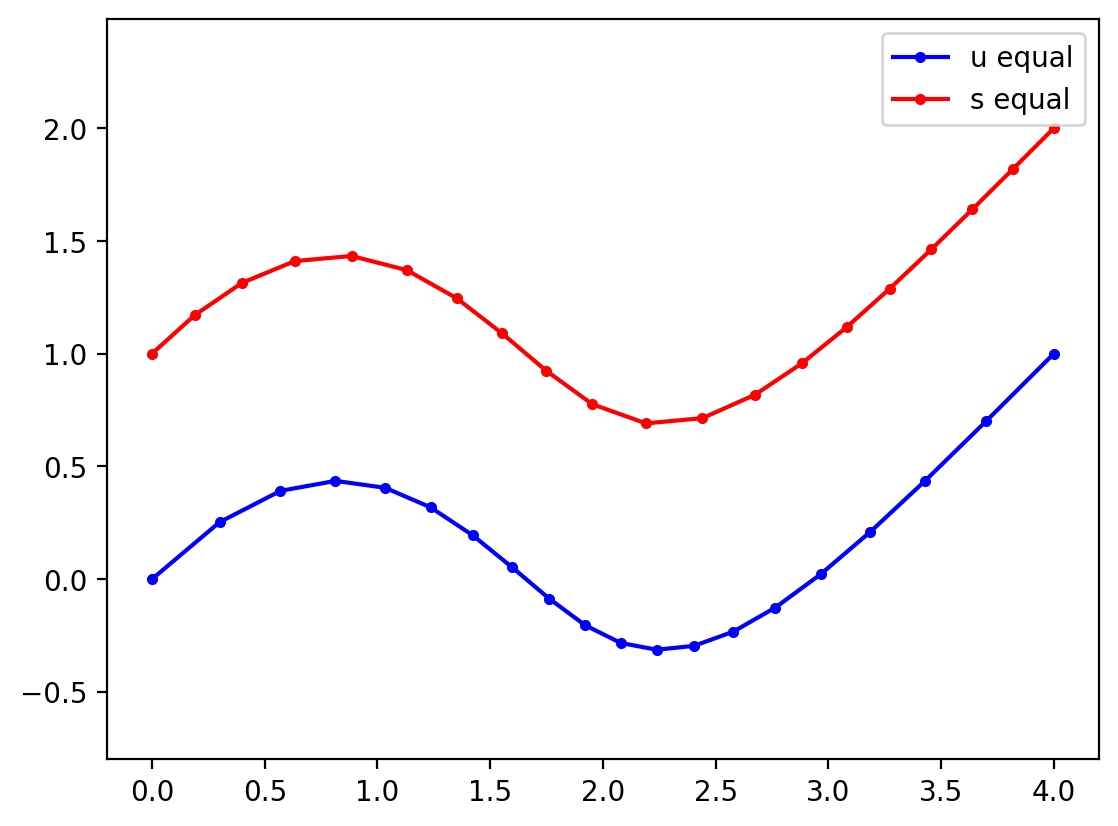

In [8]:
N = 20
# 等u划分
u_grid = np.linspace(0, 1, N)
p_u_grid = np.array([spline(u) for u in u_grid])

# 等s划分
s_grid = np.linspace(0, s_values[-1], N)
u_interp = s_to_u(s_grid)
p_s_grid = np.array([spline(u) for u in u_interp])

fig, ax = plt.subplots()
ax.plot(p_u_grid[:, 0], p_u_grid[:, 1], "b.-", label="u equal")
# 为了更好的可视化效果，将 s grid 的 y 坐标向上平移 1
ax.plot(p_s_grid[:, 0], p_s_grid[:, 1] + 1, "r.-", label="s equal")
ax.legend()
plt.axis("equal")
plt.show()